In [1]:
# TODO: Optimize MCMC code to run faster using parallelization or multithreading
# TODO: Add detailed docstrings to all functions and classes for better code documentation
# TODO: Implement unit tests
# TODO: Add more flexible parameter grid options for the models
# TODO: Investigate old code to understand why Spearman's rho used to be higher and orders were closer to the ideal order

import sys
import os

parent_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), os.pardir))
simulation_class_path = os.path.join(parent_dir, "simulation_class")
sys.path.append(simulation_class_path)

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau
from simulation_class.canonical_generator import CanonicalGenerator
from simulation_class.sample_generator import SampleGenerator
from simulation_class.disease_progression_analyzer import DiseaseProgressionAnalyzer
from simulation_class.ebm.probability_legacy import log_distributions

In [2]:
os.getcwd()

'/home/dsemchin/Progression_models_simulations'

## SIGMOID demo

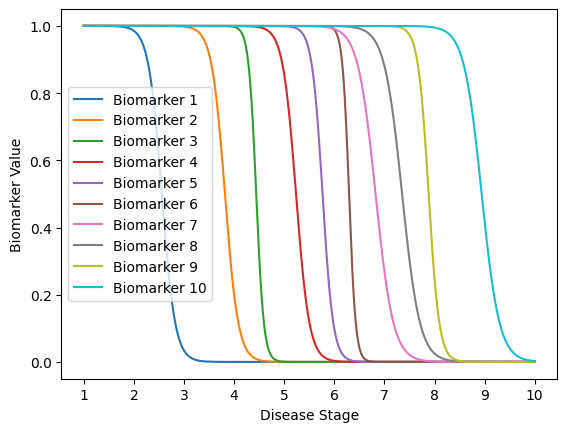

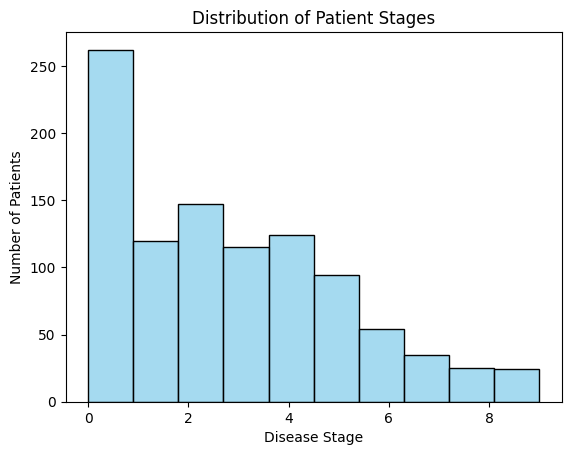

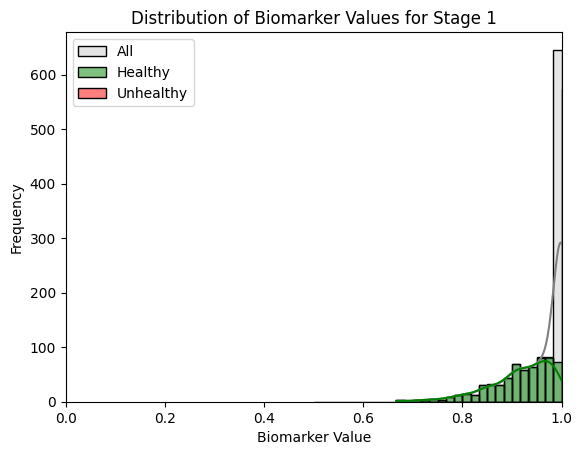

In [3]:
# model parameters
n_stages = 10
model_type = 'inv_sigmoid'
biomarkers_params_sigmoid = {
    0: {'s': 0.4, 'c': -20.6},
    1: {'s': 0.4, 'c': 3.2},
    2: {'s': 0.7, 'c': 15.0},
    3: {'s': 0.4, 'c': 30.0},
    4: {'s': 0.5, 'c': 40.0},
    5: {'s': 0.8, 'c': 50.0},
    6: {'s': 0.3, 'c': 60.0},
    7: {'s': 0.3, 'c': 70.0},
    8: {'s': 0.5, 'c': 80.0},
    9: {'s': 0.3, 'c': 90.0},
    9: {'s': 0.3, 'c': 100.0},
}

# generate the canonical model
sigmoid_model = CanonicalGenerator(n_stages, model_type, biomarkers_params=biomarkers_params_sigmoid)
sigmoid_values = sigmoid_model.get_stage_values()

# plot disease progression
sigmoid_model.plot_disease_progression()

# generate patient samples
n_patients = 1000   
sample_generator = SampleGenerator(sigmoid_values,
                                   n_patients,
                                   dist_params={'loc': 2.5, 'scale': 3, 'random_state': 2},
                                   add_noise=True,
                                   noise_std=0.1,
                                   random_state=2)

patient_samples = sample_generator.get_sample()


# plot stage histogram
sample_generator.plot_stage_histogram()
sample_generator.plot_biomarker_distribution(stage=1)

In [4]:
# run analysis
X = sample_generator.get_X()
y = sample_generator.get_y()

_, _, cdf_pe, cdf_n_pe = log_distributions(X, y)



In [5]:
analyzer = DiseaseProgressionAnalyzer(X, y)
likelihood_matrix = analyzer.run_analysis('ebm')

# get parameters including spearman's rho
params = analyzer.ebm_analyzer.get_params()
rho = params['spearman_rho']
print("Spearman's rho:", rho)

Starting Order: [7 6 5 1 4 9 8 3 0 2], kendall-tau:-0.37777777777777777, spearmanr: -0.43030303030303024


100%|██████████| 10000/10000 [00:03<00:00, 3244.22it/s]


Greedy Ascent Result: [0 1 2 3 4 6 5 7 8 9]


100%|██████████| 500000/500000 [02:34<00:00, 3232.66it/s]


[]
Best Order:0


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10 and the array at index 1 has size 1

In [5]:
# run analysis
X = sample_generator.get_X()
y = sample_generator.get_y()

starting_pos = []
best_order = []
kendall_tau = []
spearman_rho = []
greedy_ascent = []
spearman_starting_order = []
spearman_greedy_ascent = []

for i in np.arange(6):
    analyzer = DiseaseProgressionAnalyzer(X, y)
    likelihood_matrix = analyzer.run_analysis('ebm')
    params = analyzer.ebm_analyzer.get_params()
     
    starting_pos.append(params['starting_order'])
    greedy_ascent.append(params['greedy_ascent'])
    best_order.append(params['best_order'])
    kendall_tau.append(params['kendall_tau'])
    spearman_rho.append(params['spearman_rho'])
    
    ideal_order = np.arange(len(params['starting_order']))
    spearman_starting, _ = spearmanr(ideal_order, params['starting_order'])
    spearman_greedy, _ = spearmanr(ideal_order, params['greedy_ascent'])
    
    spearman_starting_order.append(spearman_starting)
    spearman_greedy_ascent.append(spearman_greedy)
    
results_df = pd.DataFrame({
    'starting_order': starting_pos,
    'greedy_ascent_order': greedy_ascent,
    'best_order': best_order,
    'kendall_tau': kendall_tau,
    'spearman_rho': spearman_rho,
    'spearman_starting_order': spearman_starting_order,
    'spearman_greedy_ascent': spearman_greedy_ascent
})
file_name = f"ebm_{model_type}_results_legacy.csv"    
results_df.to_csv(file_name, index=False)

Starting Order: [5 7 0 3 2 1 8 6 9 4], kendall-tau:0.19999999999999998, spearmanr: 0.29696969696969694


100%|██████████| 10000/10000 [00:02<00:00, 3617.63it/s]


Greedy Ascent Result: [1 2 3 4 5 6 7 8 9 0]


100%|██████████| 500000/500000 [02:19<00:00, 3588.18it/s]


Best Order:[1 2 3 4 5 6 7 8 9 0]
(1000, 10)
(1000,)
Starting Order: [1 7 8 3 0 9 5 6 4 2], kendall-tau:-0.06666666666666667, spearmanr: -0.04242424242424241


100%|██████████| 10000/10000 [00:02<00:00, 3652.10it/s]


Greedy Ascent Result: [1 0 2 3 4 5 6 7 8 9]


100%|██████████| 500000/500000 [02:17<00:00, 3640.23it/s]


Best Order:[1 0 2 3 4 5 6 7 8 9]
(1000, 10)
(1000,)
Starting Order: [6 9 3 0 1 7 8 4 5 2], kendall-tau:-0.1111111111111111, spearmanr: -0.17575757575757575


100%|██████████| 10000/10000 [00:02<00:00, 3650.72it/s]


Greedy Ascent Result: [1 2 3 4 5 6 7 8 9 0]


100%|██████████| 500000/500000 [02:18<00:00, 3617.46it/s]


Best Order:[1 2 3 4 5 6 7 8 9 0]
(1000, 10)
(1000,)
Starting Order: [7 8 0 6 2 9 1 3 5 4], kendall-tau:-0.1111111111111111, spearmanr: -0.24848484848484845


100%|██████████| 10000/10000 [00:02<00:00, 3645.05it/s]


Greedy Ascent Result: [1 0 2 3 4 5 6 7 8 9]


100%|██████████| 500000/500000 [02:18<00:00, 3615.80it/s]


Best Order:[1 0 2 3 4 5 6 7 8 9]
(1000, 10)
(1000,)
Starting Order: [2 8 9 3 1 6 5 0 4 7], kendall-tau:-0.06666666666666667, spearmanr: -0.10303030303030303


100%|██████████| 10000/10000 [00:02<00:00, 3584.47it/s]


Greedy Ascent Result: [1 0 2 3 4 5 6 7 8 9]


100%|██████████| 500000/500000 [02:20<00:00, 3569.41it/s]


Best Order:[1 0 2 3 4 5 6 7 8 9]
(1000, 10)
(1000,)
Starting Order: [1 0 7 5 9 6 8 4 2 3], kendall-tau:0.022222222222222223, spearmanr: 0.13939393939393938


100%|██████████| 10000/10000 [00:02<00:00, 3630.71it/s]


Greedy Ascent Result: [1 0 2 3 4 5 6 7 8 9]


100%|██████████| 500000/500000 [02:18<00:00, 3617.28it/s]


Best Order:[1 0 2 3 4 5 6 7 8 9]
(1000, 10)
(1000,)


### Sigmoid

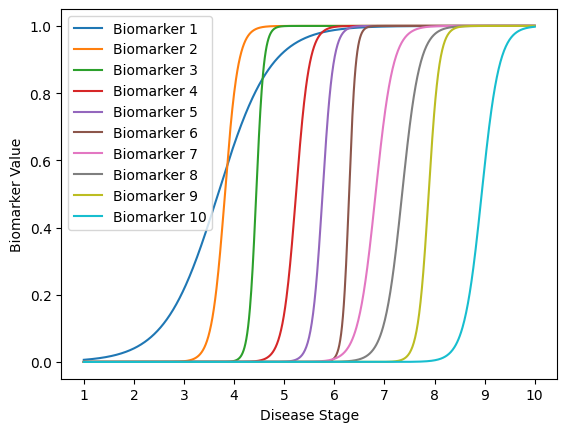

In [6]:
# model parameters
n_stages = 10
model_type = 'sigmoid'
biomarkers_params_sigmoid = {
    0: {'s': 0.1, 'c': 0.6},
    1: {'s': 0.4, 'c': 3.2},
    2: {'s': 0.7, 'c': 15.0},
    3: {'s': 0.4, 'c': 30.0},
    4: {'s': 0.5, 'c': 40.0},
    5: {'s': 0.8, 'c': 50.0},
    6: {'s': 0.3, 'c': 60.0},
    7: {'s': 0.3, 'c': 70.0},
    8: {'s': 0.5, 'c': 80.0},
    9: {'s': 0.3, 'c': 90.0},
    9: {'s': 0.3, 'c': 100.0},
}

# generate the canonical model
sigmoid_model = CanonicalGenerator(n_stages, model_type, biomarkers_params=biomarkers_params_sigmoid)
sigmoid_values = sigmoid_model.get_stage_values()
sigmoid_model.plot_disease_progression()

# generate patient samples
n_patients = 1000   
sample_generator = SampleGenerator(sigmoid_values,
                                   n_patients,
                                   dist_params={'loc': 3.5, 'scale': 3},
                                   add_noise=True,
                                   noise_std=0.1,
                                   random_state=2)

patient_samples = sample_generator.get_sample()

In [5]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

analyzer = DiseaseProgressionAnalyzer(X, y)
likelihood_matrix = analyzer.run_analysis('ebm')

# get parameters including spearman's rho
params = analyzer.ebm_analyzer.get_params()
rho = params['spearman_rho']
print("Spearman's rho:", rho)

Starting Order: [7 3 5 2 4 1 0 8 6 9], kendall-tau:0.1111111111111111


100%|██████████| 10000/10000 [00:02<00:00, 3706.75it/s]


Greedy Ascent Result: [3 4 5 6 7 8 9 0 2 1]


100%|██████████| 500000/500000 [02:17<00:00, 3641.38it/s]


Best Order:[3 4 5 6 7 8 9 0 2 1]
(1000, 10)
(1000,)
Spearman's rho: -0.28484848484848485


In [7]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

starting_pos = []
best_order = []
kendall_tau = []
spearman_rho = []
greedy_ascent = []
spearman_starting_order = []
spearman_greedy_ascent = []

for i in np.arange(6):
    analyzer = DiseaseProgressionAnalyzer(X, y)
    likelihood_matrix = analyzer.run_analysis('ebm')
    params = analyzer.ebm_analyzer.get_params()
     
    starting_pos.append(params['starting_order'])
    greedy_ascent.append(params['greedy_ascent'])
    best_order.append(params['best_order'])
    kendall_tau.append(params['kendall_tau'])
    spearman_rho.append(params['spearman_rho'])
    
    ideal_order = np.arange(len(params['starting_order']))
    spearman_starting, _ = spearmanr(ideal_order, params['starting_order'])
    spearman_greedy, _ = spearmanr(ideal_order, params['greedy_ascent'])
    
    spearman_starting_order.append(spearman_starting)
    spearman_greedy_ascent.append(spearman_greedy)
    
results_df = pd.DataFrame({
    'starting_order': starting_pos,
    'greedy_ascent_order': greedy_ascent,
    'best_order': best_order,
    'kendall_tau': kendall_tau,
    'spearman_rho': spearman_rho,
    'spearman_starting_order': spearman_starting_order,
    'spearman_greedy_ascent': spearman_greedy_ascent
})
file_name = f"ebm_{model_type}_results_legacy.csv"    
results_df.to_csv(file_name, index=False)

Starting Order: [0 9 2 1 5 7 3 8 6 4], kendall-tau:0.24444444444444444, spearmanr: 0.32121212121212117


100%|██████████| 10000/10000 [00:02<00:00, 3513.25it/s]


Greedy Ascent Result: [8 5 6 7 4 3 2 1 0 9]


100%|██████████| 500000/500000 [02:19<00:00, 3588.22it/s]


Best Order:[8 5 6 7 4 3 2 1 0 9]
(1000, 10)
(1000,)
Starting Order: [6 9 7 0 3 1 4 8 2 5], kendall-tau:-0.1111111111111111, spearmanr: -0.2606060606060606


100%|██████████| 10000/10000 [00:02<00:00, 3613.53it/s]


Greedy Ascent Result: [8 5 6 4 3 2 0 1 7 9]


100%|██████████| 500000/500000 [02:17<00:00, 3632.91it/s]


Best Order:[8 5 6 4 3 2 0 1 7 9]
(1000, 10)
(1000,)
Starting Order: [7 0 2 6 4 8 3 9 5 1], kendall-tau:0.06666666666666667, spearmanr: 0.06666666666666665


100%|██████████| 10000/10000 [00:02<00:00, 3609.63it/s]


Greedy Ascent Result: [8 5 6 4 3 2 0 1 7 9]


100%|██████████| 500000/500000 [02:18<00:00, 3609.67it/s]


Best Order:[8 5 6 4 3 2 0 1 7 9]
(1000, 10)
(1000,)
Starting Order: [8 6 1 4 3 2 0 5 7 9], kendall-tau:0.06666666666666667, spearmanr: 0.13939393939393938


100%|██████████| 10000/10000 [00:02<00:00, 3628.75it/s]


Greedy Ascent Result: [8 5 6 4 3 2 0 1 7 9]


100%|██████████| 500000/500000 [02:18<00:00, 3599.75it/s]


Best Order:[8 5 6 4 3 2 0 1 7 9]
(1000, 10)
(1000,)
Starting Order: [3 2 8 1 7 9 0 4 6 5], kendall-tau:0.06666666666666667, spearmanr: 0.1515151515151515


100%|██████████| 10000/10000 [00:02<00:00, 3603.36it/s]


Greedy Ascent Result: [8 5 6 4 3 2 0 1 7 9]


100%|██████████| 500000/500000 [02:19<00:00, 3588.34it/s]


Best Order:[8 5 6 4 3 2 0 1 7 9]
(1000, 10)
(1000,)
Starting Order: [0 6 3 1 8 9 7 5 4 2], kendall-tau:0.06666666666666667, spearmanr: 0.19999999999999998


100%|██████████| 10000/10000 [00:02<00:00, 3629.98it/s]


Greedy Ascent Result: [8 5 6 7 4 3 2 1 0 9]


100%|██████████| 500000/500000 [02:19<00:00, 3590.79it/s]


Best Order:[8 5 6 7 4 3 2 1 0 9]
(1000, 10)
(1000,)


### TRANSITION MATRIX demo

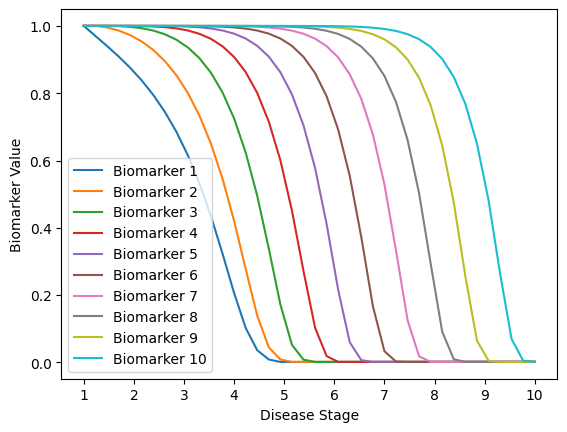

In [6]:
# model parameters
n_biomarker_stages = 10
model_type = 'transition_matrix'
biomarkers_params_transition = {'coeff': 1.5e-1}

# generate the canonical model
transition_model = CanonicalGenerator(n_biomarker_stages, model_type, biomarkers_params=biomarkers_params_transition)
transition_model.plot_disease_progression() # plot disease progression

stage_values = transition_model.get_stage_values()

# generate patient samples
sample_generator = SampleGenerator(stage_values, n_patients = 1000, add_noise=True, noise_std = 0.08, random_state=2)
patient_samples = sample_generator.patient_samples

In [8]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

analyzer = DiseaseProgressionAnalyzer(X, y)
likelihood_matrix = analyzer.run_analysis('ebm')

# get parameters including spearman's rho
params = analyzer.ebm_analyzer.get_params()
rho = params['spearman_rho']
print("Spearman's rho:", rho)

ValueError: zero-size array to reduction operation minimum which has no identity

## ODE demo

self.time_points length: 203, self.model_values[0] length: 203
self.time_points length: 203, self.model_values[1] length: 203
self.time_points length: 203, self.model_values[2] length: 203
self.time_points length: 203, self.model_values[3] length: 203
self.time_points length: 203, self.model_values[4] length: 203
self.time_points length: 203, self.model_values[5] length: 203
self.time_points length: 203, self.model_values[6] length: 203
self.time_points length: 203, self.model_values[7] length: 203
self.time_points length: 203, self.model_values[8] length: 203
self.time_points length: 203, self.model_values[9] length: 203


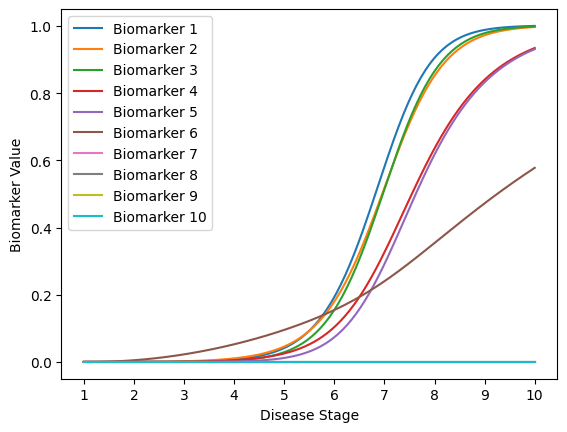

In [9]:
# TODO: add param grid options
# model parameters
n_biomarker_stages = 10
model_type = 'logistic'

# generate the canonical model
logistic_model = CanonicalGenerator(n_biomarker_stages, model_type)
logistic_values = logistic_model.get_stage_values()
logistic_model.plot_disease_progression()

# generate patient samples
n_patients = 1000   
sample_generator = SampleGenerator(logistic_values,
                                   n_patients,
                                   dist_params={'loc': 3.5, 'scale': 3},
                                   add_noise=True,
                                   noise_std=0.1,
                                   random_state=2)

patient_samples = sample_generator.get_sample()

In [ ]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

starting_pos = []
best_order = []
kendall_tau = []
spearman_rho = []
greedy_ascent = []
spearman_starting_order = []
spearman_greedy_ascent = []

for i in np.arange(6):
    analyzer = DiseaseProgressionAnalyzer(X, y)
    likelihood_matrix = analyzer.run_analysis('ebm')
    params = analyzer.ebm_analyzer.get_params()
     
    starting_pos.append(params['starting_order'])
    greedy_ascent.append(params['greedy_ascent'])
    best_order.append(params['best_order'])
    kendall_tau.append(params['kendall_tau'])
    spearman_rho.append(params['spearman_rho'])
    
    ideal_order = np.arange(len(params['starting_order']))
    spearman_starting, _ = spearmanr(ideal_order, params['starting_order'])
    spearman_greedy, _ = spearmanr(ideal_order, params['greedy_ascent'])
    
    spearman_starting_order.append(spearman_starting)
    spearman_greedy_ascent.append(spearman_greedy)
    
results_df = pd.DataFrame({
    'starting_order': starting_pos,
    'greedy_ascent_order': greedy_ascent,
    'best_order': best_order,
    'kendall_tau': kendall_tau,
    'spearman_rho': spearman_rho,
    'spearman_starting_order': spearman_starting_order,
    'spearman_greedy_ascent': spearman_greedy_ascent
})
file_name = f"ebm_{model_type}_results_legacy.csv"    
results_df.to_csv(file_name, index=False)

In [4]:
best_order = params['best_order']
print(best_order)

[8 2 0 1 3 4 5 6 7 9]


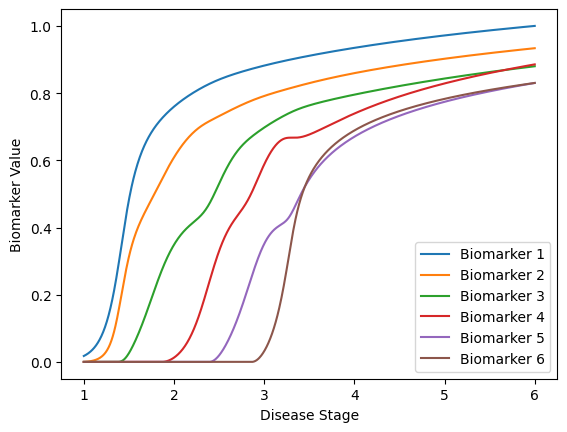

In [9]:
# TODO: add param grid options
# model parameters
n_biomarker_stages = 6
model_type = 'acp'

# generate the canonical model
logistic_model = CanonicalGenerator(n_biomarker_stages, model_type)
logistic_values = logistic_model.get_stage_values()
logistic_model.plot_disease_progression()

# generate patient samples
n_patients = 1000   
sample_generator = SampleGenerator(logistic_values,
                                   n_patients,
                                   dist_params={'loc': 3.5, 'scale': 3},
                                   add_noise=True,
                                   noise_std=0.1,
                                   random_state=2)

patient_samples = sample_generator.get_sample()

In [11]:
# run analysis
X = sample_generator.get_sample()[0]
y = sample_generator.get_sample()[1]

starting_pos = []
best_order = []
kendall_tau = []
spearman_rho = []
greedy_ascent = []
spearman_starting_order = []
spearman_greedy_ascent = []

for i in np.arange(10):
    analyzer = DiseaseProgressionAnalyzer(X, y)
    likelihood_matrix = analyzer.run_analysis('ebm')
    params = analyzer.ebm_analyzer.get_params()
     
    starting_pos.append(params['starting_order'])
    greedy_ascent.append(params['greedy_ascent'])
    best_order.append(params['best_order'])
    kendall_tau.append(params['kendall_tau'])
    spearman_rho.append(params['spearman_rho'])
    
    ideal_order = np.arange(len(params['starting_order']))
    spearman_starting, _ = spearmanr(ideal_order, params['starting_order'])
    spearman_greedy, _ = spearmanr(ideal_order, params['greedy_ascent'])
    
    spearman_starting_order.append(spearman_starting)
    spearman_greedy_ascent.append(spearman_greedy)
    
results_df = pd.DataFrame({
    'starting_order': starting_pos,
    'greedy_ascent_order': greedy_ascent,
    'best_order': best_order,
    'kendall_tau': kendall_tau,
    'spearman_rho': spearman_rho,
    'spearman_starting_order': spearman_starting_order,
    'spearman_greedy_ascent': spearman_greedy_ascent
})
file_name = f"ebm_{model_type}_results_legacy.csv"    
results_df.to_csv(file_name, index=False)

Starting Order: [3 4 0 1 2 5], kendall-tau:0.2, spearmanr: 0.14285714285714288


100%|██████████| 10000/10000 [00:01<00:00, 5822.40it/s]


Greedy Ascent Result: [5 4 3 1 0 2]


100%|██████████| 500000/500000 [01:27<00:00, 5728.33it/s]


Best Order:[5]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 6 and the array at index 1 has size 1